### Class & Module Imports

In [1]:
# - Module WAXS Classes
from WAXSAnalyze import WAXSAnalyze
from WAXSTransform import WAXSTransform
from WAXSDiffSim import WAXSDiffSim
# from WAXSExperiment import WAXSExperiment

# - Import Relevant Modules
import xarray as xr
import numpy as np
import pathlib

### Create a New Project
#### Setup DataPaths & Metadata Keys

In [2]:
# -- Core Path Definitions -- #
basePath = pathlib.Path('/Users/keithwhite/github_repositories/pyWAXS/examples')
calibPath = basePath.joinpath('calib_files/ponimask')
dataPath = basePath.joinpath('data_files')

# -- Project Specific Paths -- #
# - March 2023 @ 11-BM (CMS)
poniPath = calibPath.joinpath('may23/may23_poni4_nslsiimar23_12p7keV_CeO_KWPos_mask5_fit2.poni')
maskPath = calibPath.joinpath('may23/may23_nslsiimar23_12p7keV_AgBh_KWPos_wSi_th0p3_mask_5.edf')
zarrPath = basePath.joinpath('output_files/zarr_files')

# - June 2023 @ 11-BM (CMS)
# poniPath = calibPath.joinpath('jun23/jun23_poni_01_LaB6_5.6m_12.7keV_corrected_1150.1s_x-1.601_th0.500_5.00s_1116949_maxs.poni')
# maskPath = calibPath.joinpath('jun23/jun23_nslsii11bmcms_WAXS2pil1M_mask_03.edf')

# -- TIFF Path & Corresponding Metadata Keylist -- #
metadata_keylist = ['samplenum', 
                    'chemistry', 
                    'filter', 
                    'concentration', 
                    'purge_rate', 
                    'substrate', 
                    'solution_volume', 
                    'runnum', 
                    'clocktime', 
                    'xpos', 
                    'thpos', 
                    'exptime', 
                    'scanID', 
                    'framenum', 
                    'detext']

tiffPath = dataPath.joinpath('sam22_1MAI1PbI2_unfilt_0p3M_5p0scfh_Si_30uL_043_2068.2s_x0.015_th0.300_0.49s_986546_001639_maxs.tiff')
# tiffPath = dataPath.joinpath('/Users/keithwhite/github_repositories/pyWAXS/examples/data_files/sam27_3MAI1PbI2_unfilt_1p0M_5p0scfh_Si_30uL_046_1749.9s_x0.017_th0.300_0.49s_986653_001639_maxs.tiff')

### Create the WAXSAnalyze Project Instance

In [3]:
# - WAXSAnalyze Class Instantiation
from WAXSAnalyze import WAXSAnalyze

waxs_analysis = WAXSAnalyze(poniPath=poniPath, 
        maskPath=maskPath, 
        tiffPath=tiffPath, 
        metadata_keylist=metadata_keylist,
        energy = 12.7)

#### Normalize Image

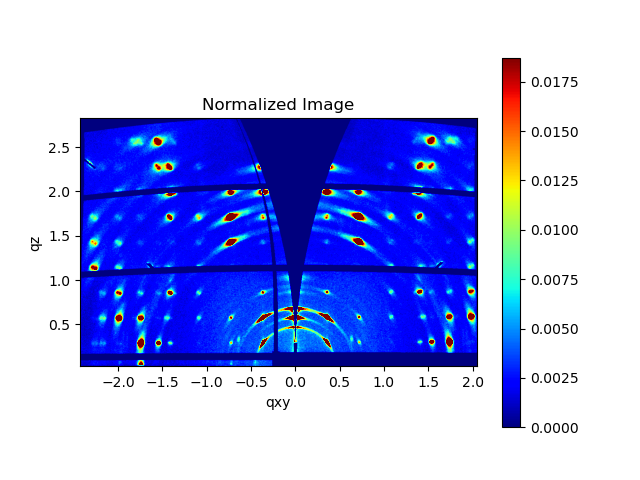

In [4]:
%matplotlib widget

# Generate the normalized reciprocal space map image
reciptiff_xr_norm = waxs_analysis.normalize_image()

# Check if the returned image is None or not of a compatible type
if reciptiff_xr_norm is None or not isinstance(reciptiff_xr_norm, (np.ndarray, xr.DataArray)):
    raise ValueError("The normalized image is None or not of a compatible type.")

# Display the normalized image
waxs_analysis.display_image(reciptiff_xr_norm, 
                            title='Normalized Image', 
                            cmap='jet')


In [ ]:
# Define coordinates for plotting based on the original image
# coords = {
#     'x_min': waxs_analysis.reciptiff_xr[waxs_analysis.inplane_config].min(),
#     'x_max': waxs_analysis.reciptiff_xr[waxs_analysis.inplane_config].max(),
#     'y_min': waxs_analysis.reciptiff_xr['q_z'].min(),
#     'y_max': waxs_analysis.reciptiff_xr['q_z'].max()
# }

#### Smoothing Image

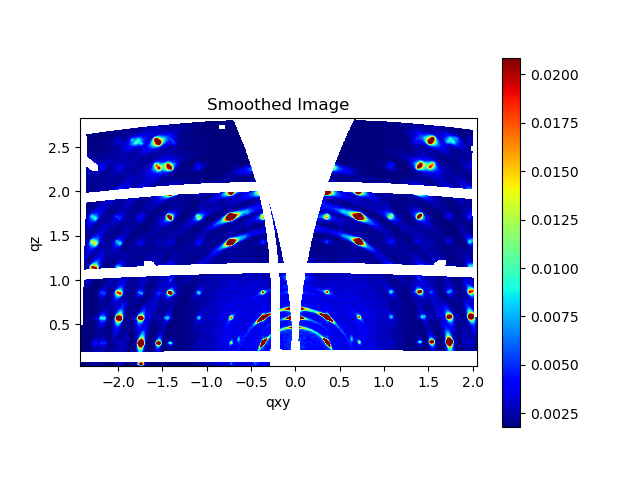

In [6]:
%matplotlib widget

# Smooth the image using the 'smooth_image' method
# smoothed_image = waxs_analysis.smooth_image(waxs_analysis.reciptiff_xr.values, 
#                                             method='gaussian', 
#                                             sigma=.05)

smoothed_image = waxs_analysis.smooth_image(reciptiff_xr_norm, 
                                            method='gaussian', 
                                            sigma=1)
# smoothed_image = waxs_analysis.normalize_image()
# smoothed_image = waxs_analysis.smooth_image(smoothed_image, method='total_variation', sigma=100)

# Display the smoothed image with appropriate coordinates using the 'display_image' method
waxs_analysis.display_image(smoothed_image, 
                            title='Smoothed Image', 
                            cmap='jet')


#### Signal-to-Noise Calculation

In [ ]:
smoothed_image = waxs_analysis.calculate_SNR(smoothed_image)
# waxs_analysis.snrtemp
waxs_analysis.reciptiff_xr.SNR

#### Peak Finder

In [ ]:
# Find peaks using the 'find_peaks' method
waxs_analysis.find_peaks()

### Plotting Methods

##### Raw Data

In [ ]:
%matplotlib widget
waxs_analysis.rawdisplay_xr()
# waxs_analysis.rawtiff_xr

##### Reciprocal Space Map

In [ ]:
%matplotlib widget
waxs_analysis.recipdisplay_xr()
# waxs_analysis.reciptiff_xr

##### Caked Image

In [ ]:
%matplotlib widget
waxs_analysis.cakeddisplay_xr()
# waxs_analysis.cakedtiff_xr

### Load an Existing Project

In [ ]:
basePath = pathlib.Path('/Users/keithwhite/github_repositories/pyWAXS/examples')
zarrPath = basePath.joinpath('output_files/zarr_files')
projectName = 'test_project'
waxs_analysis = WAXSAnalyze(zarrPath = zarrPath, projectName = projectName)

### Export the Project

In [ ]:
basePath = pathlib.Path('/Users/keithwhite/github_repositories/pyWAXS/examples')
zarrPath = basePath.joinpath('output_files/zarr_files')
projectName = 'test_project'
waxs_analysis.exportzarr(zarrPath=zarrPath, projectName=projectName)